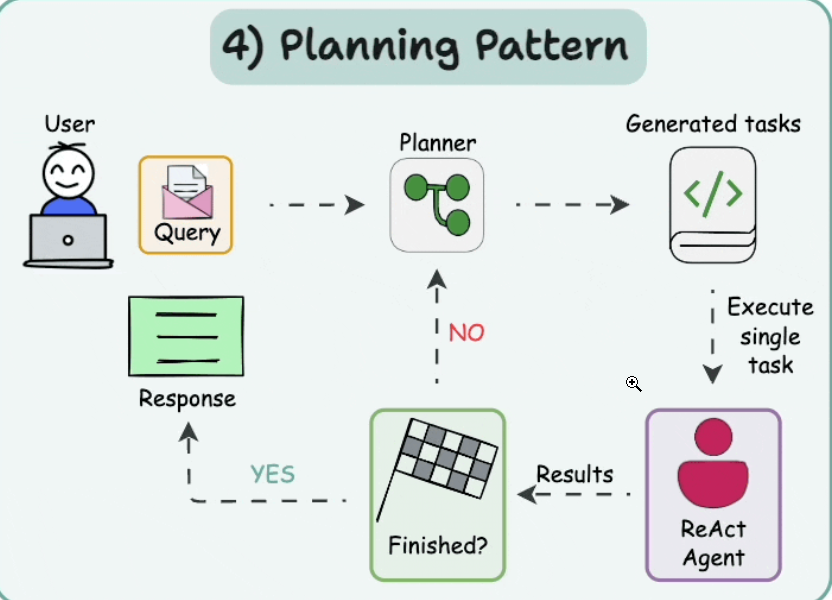

In [1]:
import IPython
import sys

def clean_notebook():
    IPython.display.clear_output(wait=True)
    print("Notebook cleaned.")

!pip install openai 

# Clean up the notebook
clean_notebook()


Notebook cleaned.


In [2]:
import os
from openai import OpenAI
import json
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

True

In [3]:
import os
from openai import OpenAI
import random

# Set up OpenAI client
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
model_name = "gpt-4o"  # Using 'gpt-4o' as a stand-in; change if needed to 'gpt-4.1' or another model

In [4]:
# Function 1: Get the current weather for a city
def get_weather(city):
    """
    Fetches the current weather for a specified city.
    Args:
        city (str): The name of the city.
    Returns:
        str: A string describing the current weather.
    """
    weather_data = {
        "New York": "Cloudy, 68°F",
        "London": "Rainy, 15°C",
        "Tokyo": "Sunny, 25°C",
        "Bangkok": "Hot and humid, 32°C",
    }
    return f"The weather in {city} is {weather_data.get(city, 'Unknown')}"

# Function 2: Get the current time for a city
def get_time(city):
    """
    Gets the current local time for a specified city.
    Args:
        city (str): The name of the city.
    Returns:
        str: A string with the current time.
    """
    time_data = {
        "New York": "10:00 AM",
        "London": "3:00 PM",
        "Tokyo": "12:00 AM",
        "Bangkok": "5:00 AM",
    }
    return f"The current time in {city} is {time_data.get(city, 'Unknown')}"

# Function 3: Search for a product online
def search_product(product_name):
    """
    Simulates an online product search.
    Args:
        product_name (str): The name of the product to search for.
    Returns:
        str: A simulated search result.
    """
    return f"Searching for '{product_name}'... Found several results on Amazon and eBay."

# Function 4: Calculate the square of a number
def calculate_square(number):
    """
    Calculates the square of a given number.
    Args:
        number (float): The number to square.
    Returns:
        float: The square of the number.
    """
    try:
        return float(number) ** 2
    except ValueError:
        return "Invalid input. Please provide a number."

# Function 5: Find a nearby restaurant
def find_restaurant(location):
    """
    Finds a nearby restaurant based on a location.
    Args:
        location (str): The user's current location.
    Returns:
        str: A list of nearby restaurants.
    """
    return f"Searching for restaurants near {location}... Found 'Burger King', 'Sushi House', and 'Italian Bistro'."

# Dictionary to map function names to the actual functions
tools = {
    "get_weather": get_weather,
    "get_time": get_time,
    "search_product": search_product,
    "calculate_square": calculate_square,
    "find_restaurant": find_restaurant,
}

In [5]:
tool_definitions = [
        {
            "type": "function",
            "function": {
                "name": "get_weather",
                "description": "Fetches the current weather for a specified city.",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "city": {"type": "string", "description": "The name of the city, e.g., 'San Francisco'"},
                    },
                    "required": ["city"],
                },
            }
        },
        {
            "type": "function",
            "function": {
                "name": "get_time",
                "description": "Gets the current local time for a specified city.",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "city": {"type": "string", "description": "The name of the city, e.g., 'New York'"},
                    },
                    "required": ["city"],
                },
            }
        },
        {
            "type": "function",
            "function": {
                "name": "search_product",
                "description": "Simulates an online product search.",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "product_name": {"type": "string", "description": "The name of the product."},
                    },
                    "required": ["product_name"],
                },
            }
        },
        {
            "type": "function",
            "function": {
                "name": "calculate_square",
                "description": "Calculates the square of a given number.",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "number": {"type": "number", "description": "The number to square."},
                    },
                    "required": ["number"],
                },
            }
        },
        {
            "type": "function",
            "function": {
                "name": "find_restaurant",
                "description": "Finds a nearby restaurant based on a location.",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "location": {"type": "string", "description": "The user's current location."},
                    },
                    "required": ["location"],
                },
            }
        },
    ]


In [6]:
def react_agent(task_description):
    """
    A simple ReAct agent that chooses and calls a tool based on a task.
    Args:
        task_description (str): The task generated by the planning agent.
    Returns:
        str: The result from the executed tool.
    """
    messages = [
        {"role": "system", "content": "You are a helpful assistant. Use the provided tools to respond to the user's request. Only use the tools when necessary."},
        {"role": "user", "content": task_description}
    ]

    
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=messages,
        tools=tool_definitions,
        tool_choice="auto",
    )

    response_message = response.choices[0].message
    tool_calls = response_message.tool_calls

    if tool_calls:
        # Call the appropriate tool
        for tool_call in tool_calls:
            function_name = tool_call.function.name
            function_to_call = tools[function_name]
            function_args = json.loads(tool_call.function.arguments)
            
            # Execute the function and return the result
            function_result = function_to_call(**function_args)
            return function_result
    else:
        # No tool call needed, just return the response content
        return response_message.content

In [7]:
import json

def planning_agent(query):
    """Breaks down a user query into a list of tasks."""
    system_prompt = """You are a planning agent. Your job is to take a user's request and break it down into a list of simple, single-step tasks that can be executed by another agent. 
    Each task should be a single, clear instruction. For example, if the user asks "What's the weather in Tokyo and the time in New York?", you should generate two tasks: 
    ['Get the weather in Tokyo', 'Get the time in New York']. 
    Respond with a JSON object containing a key named 'tasks' that holds the list of strings.
    """
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": query}
    ]

    response = client.chat.completions.create(
        model="gpt-4o",
        messages=messages,
        response_format={"type": "json_object"}
    )
    
    try:
        content = json.loads(response.choices[0].message.content)
        if isinstance(content, list):
            # The LLM returned a list directly
            return content
        elif isinstance(content, dict) and "tasks" in content:
            # The LLM returned the expected dictionary with a 'tasks' key
            return content["tasks"]
        else:
            # Handle unexpected formats
            print(f"Warning: Unexpected JSON format received: {content}")
            return ["Could not generate tasks. Please try again with a simpler query."]
    except (json.JSONDecodeError, KeyError) as e:
        print(f"Error parsing JSON: {e}")
        return ["Could not generate tasks. Please try again with a simpler query."]

In [8]:
def execute_planning_pattern(query):
    """
    Orchestrates the entire process: Planning Agent -> ReAct Agent -> Final Response.
    """
    print(f"User Query: {query}\n")

    # 1. Planning Agent breaks down the query
    print("🤖 Planning Agent: Generating tasks...")
    tasks = planning_agent(query)
    print(f"Generated tasks: {tasks}\n")

    results = []
    messages = [
        {"role": "system", "content": "You are a helpful assistant. Use the provided tools to respond to the user's request. Only use the tools when necessary."},
        {"role": "user", "content": query}
    ]

    for task in tasks:
        # 2. ReAct Agent executes each task
        print(f"⚙️ ReAct Agent: Executing task '{task}'...")
        result = react_agent(task)
        print(f"ReAct Agent Result: {result}\n")
        results.append(str(result))
    
    # Combine results and generate a final response
    final_response_message = "".join(results)

    print("final response message from React:", final_response_message)

    messages = [
        {"role": "system", "content": f"You are a helpful assistant. with the following information: {final_response_message}"},
        {"role": "user", "content": query},
    
    ]

    final_response = client.chat.completions.create(
        model="gpt-4o",
        messages=messages
    ).choices[0].message.content

    print(f"\nFinal Response: {final_response}")
    return final_response

In [9]:

test_questions = [
    # Complex query 1: Combines weather and time for multiple cities.
    "สภาพอากาศที่โตเกียวและนิวยอร์กเป็นอย่างไร และเวลาท้องถิ่นที่ลอนดอนคือเมื่อไหร่?",
    
    # Complex query 2: Combines a mathematical calculation, a product search, and a weather query.
    "ฉันต้องการทราบกำลังสองของ 9 และช่วยค้นหา 'โทรศัพท์มือถือ' ให้ฉันที แล้วบอกสภาพอากาศที่กรุงเทพด้วย",
    
    # Complex query 3: Combines a restaurant search with a calculation and a product search.
    "ช่วยหาร้านอาหารใกล้หอไอเฟล และคำนวณกำลังสองของ 15 แล้วค้นหา 'กล้องถ่ายรูป' ให้ฉัน",
    
    # Complex query 4: A more complex version of a simple query, asking for multiple pieces of information about a single city.
    "บอกฉันเกี่ยวกับนิวยอร์กหน่อย: สภาพอากาศเป็นอย่างไร และตอนนี้กี่โมงแล้ว?",
    
    # Complex query 5: Combines multiple calculations and a product search.
    "กำลังสองของ 75 และ 20 คือเท่าไหร่ และช่วยค้นหา 'หูฟังไร้สาย' ให้ฉันที",
    
    # Complex query 6: Combines a product search, a restaurant search, and a time query.
    "ฉันต้องการซื้อ 'รองเท้าวิ่ง' ช่วยค้นหาให้หน่อย และบอกฉันว่ามีร้านอาหารใกล้ฉันไหม แล้วเวลาที่โตเกียวคือเมื่อไหร่?",
    
    # Complex query 7: Combines two mathematical calculations and a weather query for a city not in the initial data.
    "กำลังสองของ 32 และ 64 คืออะไร และสภาพอากาศในซานฟรานซิสโกเป็นอย่างไร?",
    
    # Complex query 8: Combines a restaurant search and a product search with a request for a calculation.
    "ฉันหิวมาก มีร้านอาหารใกล้กรุงเทพไหม? และช่วยค้นหา 'ตั๋วเครื่องบิน' แล้วคำนวณกำลังสองของ 10",
    
    # Complex query 9: A very complex query with multiple independent tasks.
    "ตอนนี้ลอนดอนกี่โมง? และกำลังสองของ 10 คืออะไร? และช่วยค้นหา 'หนังสือทำอาหาร' ให้ฉันหน่อย แล้วมีร้านอาหารใกล้บ้านฉันไหม?",
    
    # Complex query 10: A combination of calculations, a product search, and a time query.
    "ช่วยคำนวณกำลังสองของ 12 และ 16 และค้นหา 'กระเป๋าสะพาย' และบอกเวลาที่นิวยอร์ก",
]

for i, query in enumerate(test_questions):
    print(f"--- Running Test Case {i+1}/{len(test_questions)} ---")
    execute_planning_pattern(query)
    print("\n" + "="*50 + "\n") # Separator for clarity

--- Running Test Case 1/10 ---
User Query: สภาพอากาศที่โตเกียวและนิวยอร์กเป็นอย่างไร และเวลาท้องถิ่นที่ลอนดอนคือเมื่อไหร่?

🤖 Planning Agent: Generating tasks...
Generated tasks: ['Get the weather in Tokyo', 'Get the weather in New York', 'Get the local time in London']

⚙️ ReAct Agent: Executing task 'Get the weather in Tokyo'...
ReAct Agent Result: The weather in Tokyo is Sunny, 25°C

⚙️ ReAct Agent: Executing task 'Get the weather in New York'...
ReAct Agent Result: The weather in New York is Cloudy, 68°F

⚙️ ReAct Agent: Executing task 'Get the local time in London'...
ReAct Agent Result: The current time in London is 3:00 PM

final response message from React: The weather in Tokyo is Sunny, 25°CThe weather in New York is Cloudy, 68°FThe current time in London is 3:00 PM

Final Response: สภาพอากาศที่โตเกียวเป็นแดดออก และอุณหภูมิ 25°C สำหรับนิวยอร์ค สภาพอากาศมีเมฆมาก และอุณหภูมิ 68°F ส่วนเวลาท้องถิ่นที่ลอนดอนคือ 3:00 PM ค่ะ


--- Running Test Case 2/10 ---
User Query: ฉันต้องการทราบ